In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Problem Statement:
An airline company has the data of the number of passengers that have travelled with them on a particular route for the past few years. They want to see if they can forecast the number of passengers for the next 2 years.

In [2]:
df=pd.read_csv("https://raw.githubusercontent.com/Premalatha-success/Datasets/main/airline-passenger-traffic.csv")

In [3]:
df.head()

,1949-01,112
0,1949-02,118.0
1,1949-03,132.0
2,1949-04,129.0
3,1949-05,121.0
4,1949-06,135.0


In [4]:
df.shape

(143, 2)

In [5]:
df.isnull().sum()

1949-01    0
112        4
dtype: int64

In [6]:
df.dtypes

1949-01     object
112        float64
dtype: object

In [7]:
df['112']=df['112'].replace(to_replace=0, value=np.nan)
df['112']=df['112'].astype(float)
mean=df['112'].mean()
df['112'].replace(np.nan,mean,inplace=True)
mean

281.9496402877698

In [8]:
duplicate=df.duplicated()
print(duplicate.sum())
df[duplicate]

0


,1949-01,112


In [9]:
df = df.rename(columns={'1949-01': 'Date','112':'No.of Passengers'})

In [10]:
df['Date']=pd.to_datetime(df['Date'])

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              143 non-null    datetime64[ns]
 1   No.of Passengers  143 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.4 KB


In [12]:
df.set_index('Date',inplace=True)
df.index

DatetimeIndex(['1949-02-01', '1949-03-01', '1949-04-01', '1949-05-01',
               '1949-06-01', '1949-07-01', '1949-08-01', '1949-09-01',
               '1949-10-01', '1949-11-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Date', length=143, freq=None)

In [13]:
y=df['No.of Passengers'].resample('Y').mean()

y.head(10)

Date
1949-12-31    128.000000
1950-12-31    139.666667
1951-12-31    185.741607
1952-12-31    197.000000
1953-12-31    225.000000
1954-12-31    240.412470
1955-12-31    284.000000
1956-12-31    328.250000
1957-12-31    368.416667
1958-12-31    381.000000
Freq: A-DEC, Name: No.of Passengers, dtype: float64

In [14]:
y.isnull().sum()

0

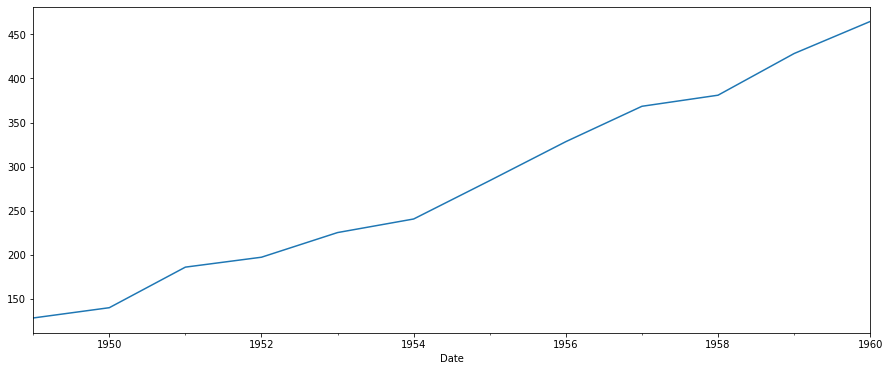

In [15]:
y.plot(figsize=(15,6))
plt.show()

C:\Users\Murali krishna\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\Murali krishna\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


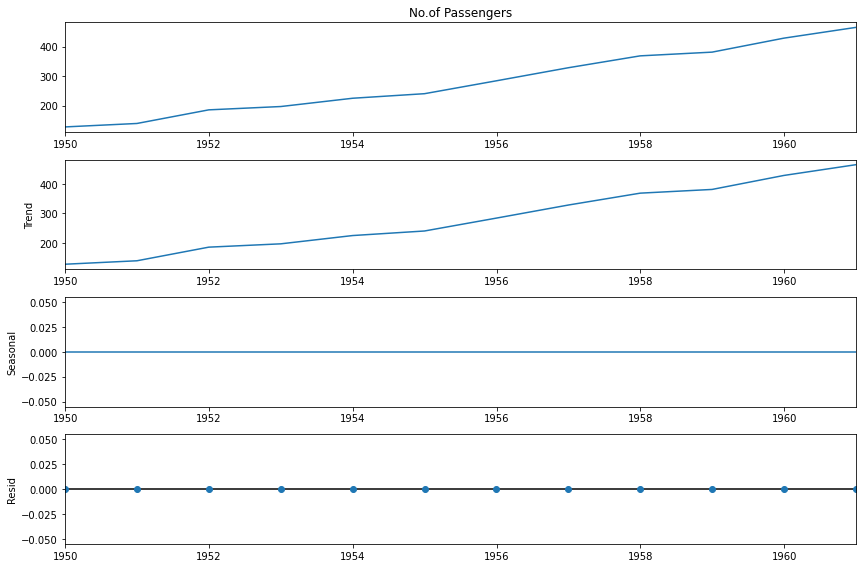

In [16]:
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")
from pylab import rcParams

rcParams['figure.figsize']=12,8

decomposition=sm.tsa.seasonal_decompose(y,model='additive')

fig=decomposition.plot()

plt.show()

### There is no sessionality and error.Trend is upwards trend

### Here Additive model is used and is best when sessionality is constant over time

### Using Augmented Dickey-Fuller Test to test Stationarity.
#### Null Hypothesis:Data is non-stationary.
#### Alternate Hypothesis:Data is stationary.
#### if ADF Statistics<Critical values then Null Hypothesis is rejected i.e, Data is Stationary.

In [17]:
from statsmodels.tsa.stattools import adfuller
from pandas import Series
result=adfuller(y)
print('ADF Statistic: %f' % result[0])
print('P-value: %f' % result[1])
print('Critical Values:')
for key,value in result[4].items():
    print('\t%s: %.3f' % (key,value))

ADF Statistic: 1.719038
P-value: 0.998174
Critical Values:
	1%: -4.939
	5%: -3.478
	10%: -2.844


### Here Statistic value is greater than critical values  i.e,Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.

### Applying log transformation to the data to make non-stationary to Stationary

In [18]:
from pandas import read_csv
from statsmodels.tsa.stattools import adfuller
from numpy import log
y = log(y)
result = adfuller(y)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.188563
p-value: 0.210422
	1%: -4.939
	5%: -3.478
	10%: -2.844


### Here the data is still non-stationary

### Applying Manual Differencing transformation

In [19]:
# create a differenced series
def difference(y, interval=1):
    diff = list()
    for i in range(interval, len(y)):
        value = y[i] - y[i - interval]
        diff.append(value)
    return Series(diff)
diff = difference(y)
#pyplot.plot(diff)
#pyplot.show()
result = adfuller(diff)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.245995
p-value: 0.000550
	1%: -4.332
	5%: -3.233
	10%: -2.749


### Statistics value is less than 5% critical value ,hence the data became Stationary at 5% Critical value.

## Applying ARIMA model for Forecasting

In [20]:
import statsmodels.api as sm
import itertools
p=d=q=range(0,2)
pdq=list(itertools.product(p,d,q))
seasonal_pdq=[(x[0],x[1],x[2],12) for x in list(itertools.product(p,d,q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1],seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1],seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2],seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2],seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [21]:
from pylab import rcParams
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod=sm.tsa.statespace.SARIMAX(y,order=param,
seasonal_order=param_seasonal,
enforce_stationarity=False,
enforce_invertibility=False)
            results=mod.fit()
            print('ARIMA{}x{}12 -AIC:{}'.format(param,param_seasonal,results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 -AIC:71.25023986843091
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 -AIC:4.0
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 -AIC:2.0
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 -AIC:4.0
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 -AIC:4.0
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 -AIC:6.0
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 -AIC:4.0
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 -AIC:6.0
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 -AIC:56.59384174694575
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 -AIC:6.0
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 -AIC:4.0
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 -AIC:6.0
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 -AIC:6.0
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 -AIC:8.0
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 -AIC:6.0
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 -AIC:8.0
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 -AIC:-9.23609509577485
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 -AIC:4.0
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 -AIC:2.0
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 -AIC:4.0
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 -AIC:4.0
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 -AIC:6.0
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 -AIC:4.0
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 -AIC:6.

In [22]:
from pylab import rcParams
a=[]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod=sm.tsa.statespace.SARIMAX(y,order=param,
seasonal_order=param_seasonal,
enforce_stationarity=False,
enforce_invertibility=False)
            results=mod.fit()
            a.append(results.aic)
        except:
            continue
print(min(a))#(1, 0, 0)x(0, 0, 0, 12)

-23.65218028240765


In [23]:
mod=sm.tsa.statespace.SARIMAX(y,
                             order=(1,0,0),
                             seasonal_order=(0,0,0,12),
                             enforce_invertibility=False)
results=mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9997      0.002    407.501      0.000       0.995       1.005
sigma2         0.0180      0.009      1.960      0.050     2.8e-06       0.036


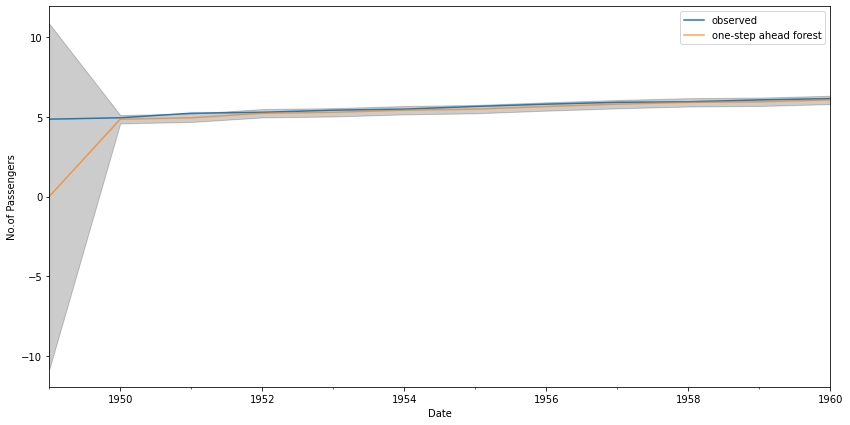

In [24]:
#set forecasts to start at 1949-12-31 to the end of the data of forecast
pred=results.get_prediction(start=pd.to_datetime('1949-12-31'),dynamic=False)
pred_ci=pred.conf_int()
ax=y['1949':].plot(label='observed')
pred.predicted_mean.plot(ax=ax,label='one-step ahead forest',alpha=0.7,figsize=(14,7))
ax.fill_between(pred_ci.index,
               pred_ci.iloc[:,0],
               pred_ci.iloc[:,1],color='k',alpha=0.2)
ax.set_xlabel('Date')
ax.set_ylabel('No.of Passengers')
plt.legend()
plt.show()

            lower No.of Passengers  upper No.of Passengers
1961-12-31                5.876786                6.402587
1962-12-31                5.766139                6.509626
1963-12-31                5.680856                6.591303
1964-12-31                5.608707                6.659847
1965-12-31                5.544956                6.719994
1966-12-31                5.487173                6.774173
1967-12-31                5.433915                6.823830
1968-12-31                5.384240                6.869903
1969-12-31                5.337495                6.913048
1970-12-31                5.293205                6.953740
1971-12-31                5.251009                6.992337
1972-12-31                5.210629                7.029120
1973-12-31                5.171843                7.064311


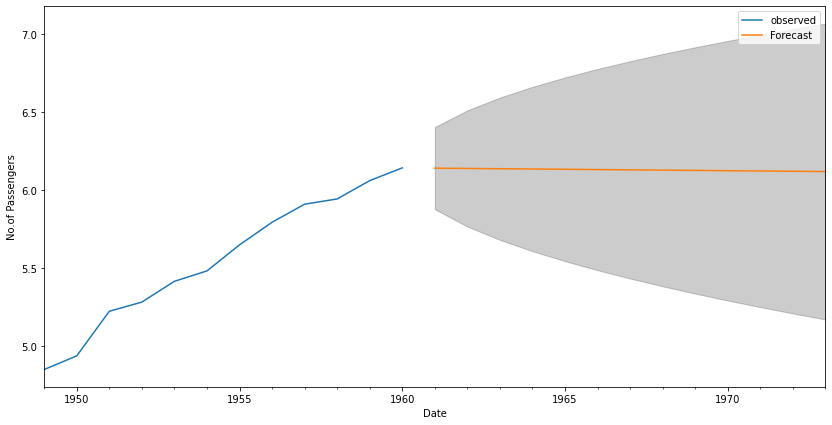

In [25]:
 pred_uc=results.get_forecast(steps=13)
pred_ci=pred_uc.conf_int()
ax=y.plot(label="observed",figsize=(14,7))
pred_uc.predicted_mean.plot(ax=ax,label="Forecast")
ax.fill_between(pred_ci.index,
               pred_ci.iloc[:,0],
               pred_ci.iloc[:,1],color="k",alpha=.2)
ax.set_xlabel("Date")
ax.set_ylabel("No.of Passengers")
print(pred_ci)
plt.legend()
plt.show()

### Count of Passengers were increased till 1960 and becomes constant next few years.